# training

In [ ]:
!pip install efficientnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB3  # Import EfficientNetB3 model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
img_w, img_h = 224, 224
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"
dataset_path


In [ ]:
# Using rescales, shear_range, zoom_ranges, horizontal_flip for trainings data augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

# Only rescales for validations data (no augmentations)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# for trainings
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch,
    class_mode='categorical',
    subset='training'  # Specifys this is for trainings set
)

# for validations
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(imge_w, img_h),
    batch_size=batch,
    class_mode='categorical',
    subset='validation'  # Specifys this is for validations set
)

Found 11397 images belonging to 4 classes.
Found 2848 images belonging to 4 classes.


In [ ]:
img_w, img_h = 224, 224
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"
dataset_path


In [ ]:
img_w, img_h = 224, 224
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"
dataset_path


In [ ]:
img_w, img_h = 224, 224
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"
dataset_path


In [ ]:
img_w, img_h = 224, 224
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"
dataset_path


In [ ]:
num_classes = train_generator.num_classes
num_classes

4

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
base_model = EfficientNetB3(weights='imagenet', include_top=False)

# Add tops layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)a

# Creates models
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tunes
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch,
    epochs=16,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch
)


c:\Users\admin\anaconda3\envs\malak1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/16
356/356 [==============================] - 139s 355ms/step - loss: 0.2890 - accuracy: 0.8991 - val_loss: 0.6011 - val_accuracy: 0.8202
Epoch 2/16
356/356 [==============================] - 71s 199ms/step - loss: 0.1458 - accuracy: 0.9543 - val_loss: 0.0807 - val_accuracy: 0.9803
Epoch 3/16
356/356 [==============================] - 71s 200ms/step - loss: 0.0966 - accuracy: 0.9682 - val_loss: 0.0790 - val_accuracy: 0.9782
Epoch 4/16
356/356 [==============================] - 71s 199ms/step - loss: 0.0889 - accuracy: 0.9722 - val_loss: 0.2367 - val_accuracy: 0.9196
Epoch 5/16
356/356 [==============================] - 71s 199ms/step - loss: 0.0649 - accuracy: 0.9809 - val_loss: 0.0283 - val_accuracy: 0.9905
Epoch 6/16
356/356 [==============================] - 72s 201ms/step - loss: 0.0683 - accuracy: 0.9787 - val_loss: 0.1430 - val_accuracy: 0.9624
Epoch 7/16
356/356 [==============================] - 71s 200ms/step - loss: 0.0657 - accuracy: 0.9784 - val_loss: 0.1168 - val_a

In [ ]:
model.save_weights(r"/content/drive/MyDrive/model_weights/efficientnetb3_Latest.h5")


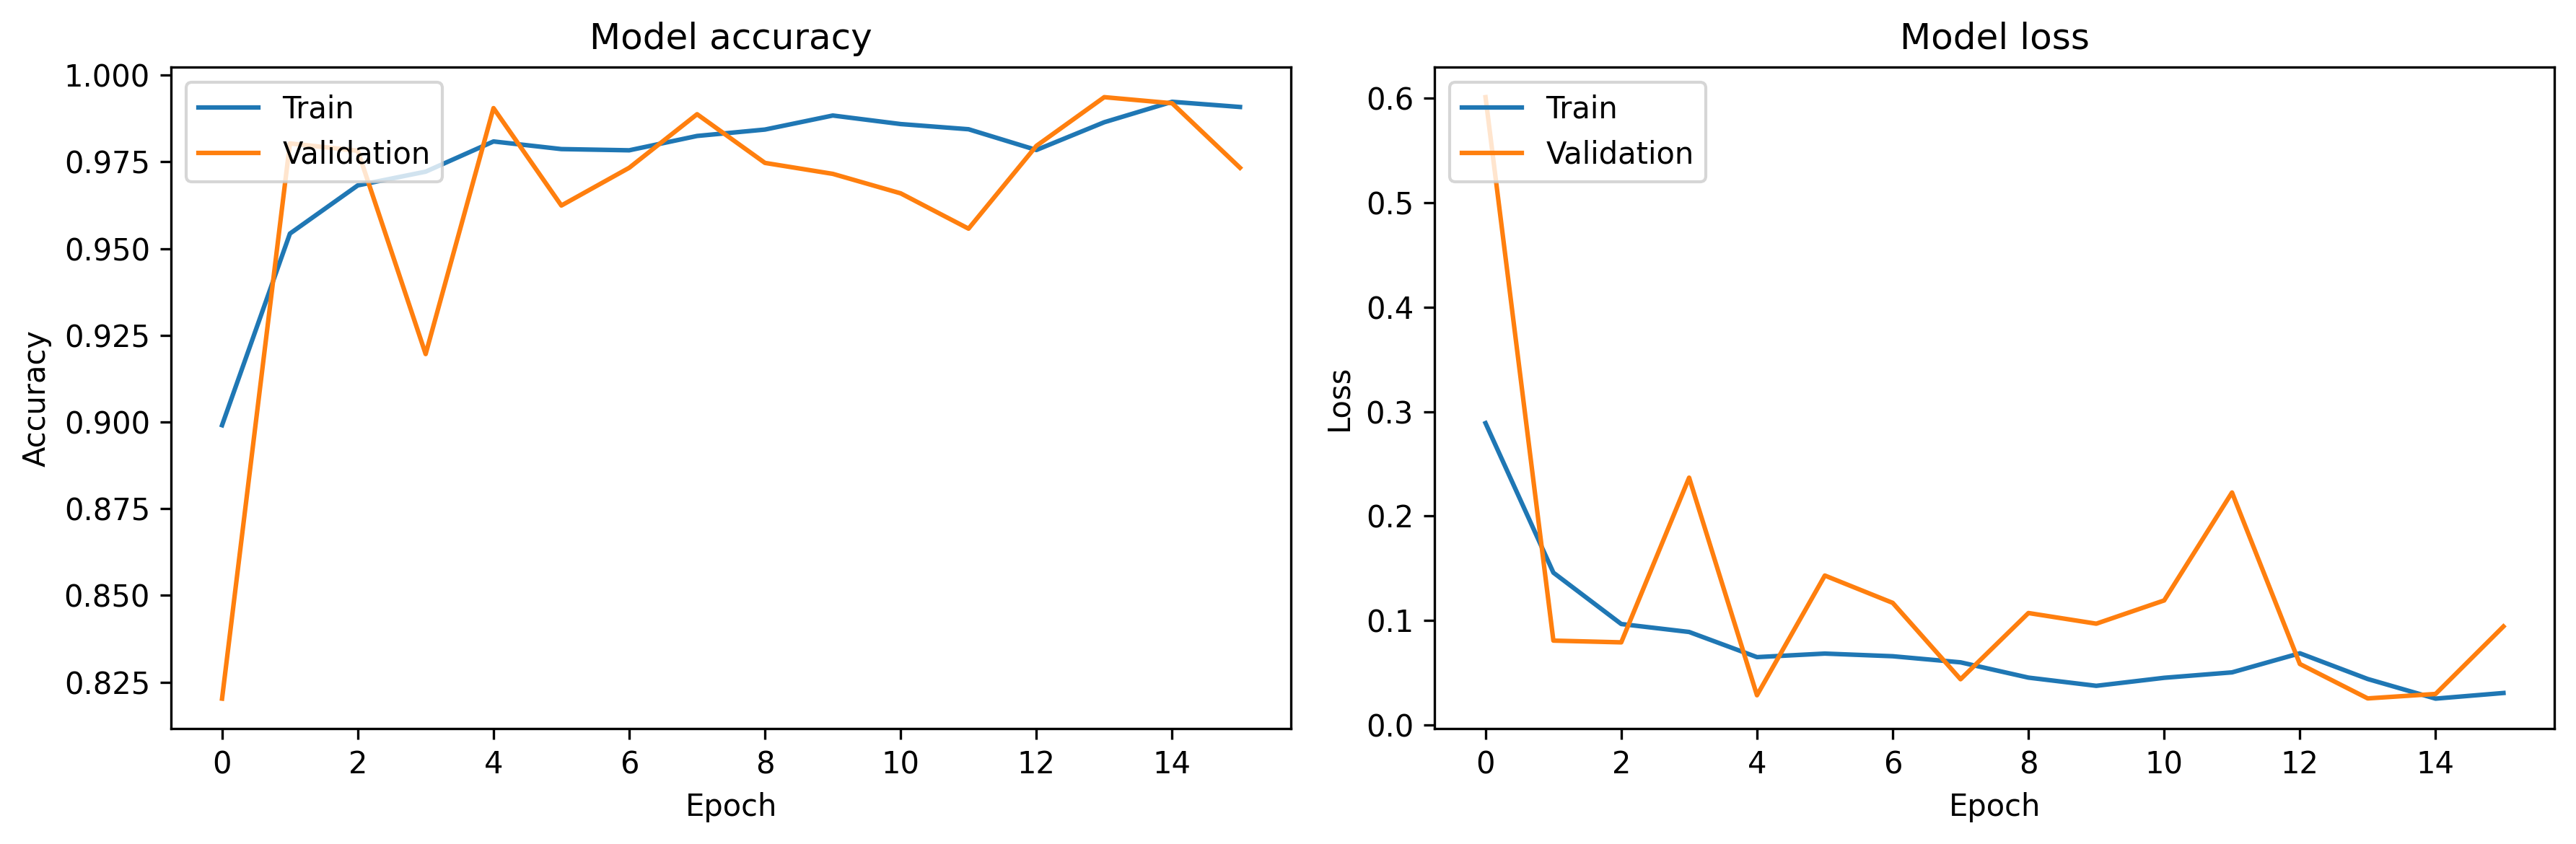

In [ ]:
# show graphs for trainings & validations accuracy value
plt.figure(figsize=(12, 4) ,dpi=300)

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# shows graphs for trainings & validations loss value
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

89/89 [==============================] - 5s 46ms/step


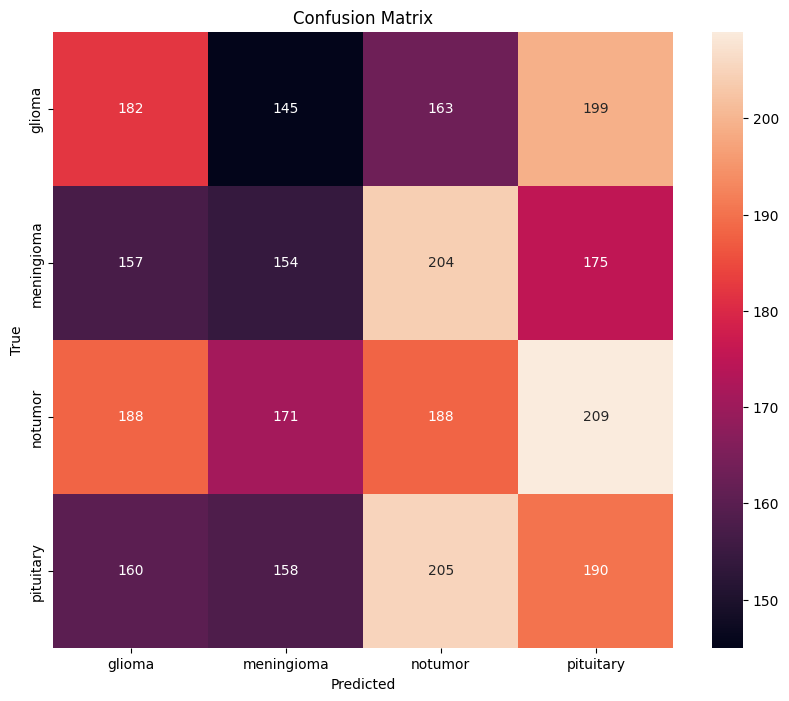

Classification Report
              precision    recall  f1-score   support

      glioma       0.26      0.26      0.26       689
  meningioma       0.25      0.22      0.23       690
     notumor       0.25      0.25      0.25       756
   pituitary       0.25      0.27      0.26       713

    accuracy                           0.25      2848
   macro avg       0.25      0.25      0.25      2848
weighted avg       0.25      0.25      0.25      2848



In [ ]:
import seaborn as sns
# Obtains true label and prediction
validation_generator.reset()
Y_pred = model.predict(validation_generator, validation_generator.n // batch + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Creates confusions matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plots confusions matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

In [ ]:
images, labels = next(validation_generator)

In [ ]:
len(labels)

32

In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
images, labels = next(validation_generator)
images = images[:num_images]
labels = labels[:num_images]

In [ ]:
def get_predictions(generator, model, num_images):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    predictions = model.predict(images)
    actual_classes = [classes[np.argmax(label)] for label in labels]
    predicted_classes = [classes[np.argmax(prediction)] for prediction in predictions]
    return images, actual_classes, predicted_classes

1/1 [==============================] - 0s 25ms/step


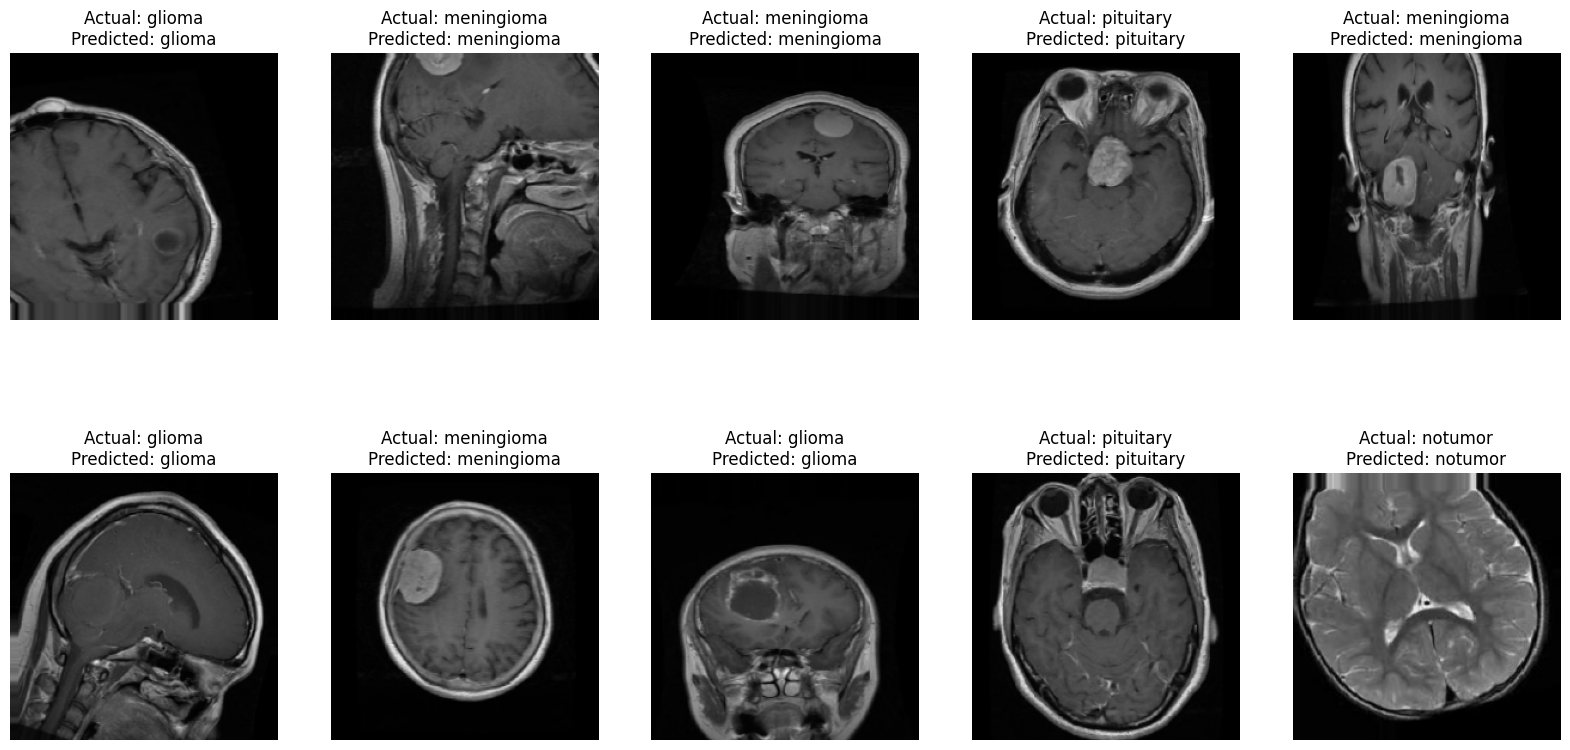

In [ ]:
num_images = 10
images, actual_classes, predicted_classes = get_predictions(train_generator, model, num_images)

# shows the image with their actual and predicteds class name
plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Actual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}')
    plt.axis('off')
plt.show()

# EfficientNetB3  Evaluation



In [ ]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_w, img_h = 224, 224
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"


In [ ]:
# Using rescales, shear_ranges, zoom_ranges, horizontal_flip for trainings data augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

# Only rescales for validations data (no augmentations)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# trainings Trainings
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch,
    class_mode='categorical',
    subset='training'  # Specify this is for training set
)

#for  Validations
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch,
    class_mode='categorical',
    subset='validation'  # Specify this is for validation set
)

Found 11397 images belonging to 4 classes.
Found 2848 images belonging to 4 classes.


In [ ]:
num_classes = train_generator.num_classes
num_classes

4

In [ ]:
from tensorflow.keras.models import load_model

path = r"/content/drive/MyDrive/model_weights/efficientnetb3_Latest.h5"
model = load_model(path)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

In [ ]:
images, labels = next(validation_generator)

In [ ]:
len(labels)

32

In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
num_images =10
images, labels = next(validation_generator)
images = images[:num_images]
labels = labels[:num_images]

In [ ]:
def get_predictions(generator, model, num_images):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    predictions = model.predict(images)
    actual_classes = [classes[np.argmax(label)] for label in labels]
    predicted_classes = [classes[np.argmax(prediction)] for prediction in predictions]
    return images, actual_classes, predicted_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


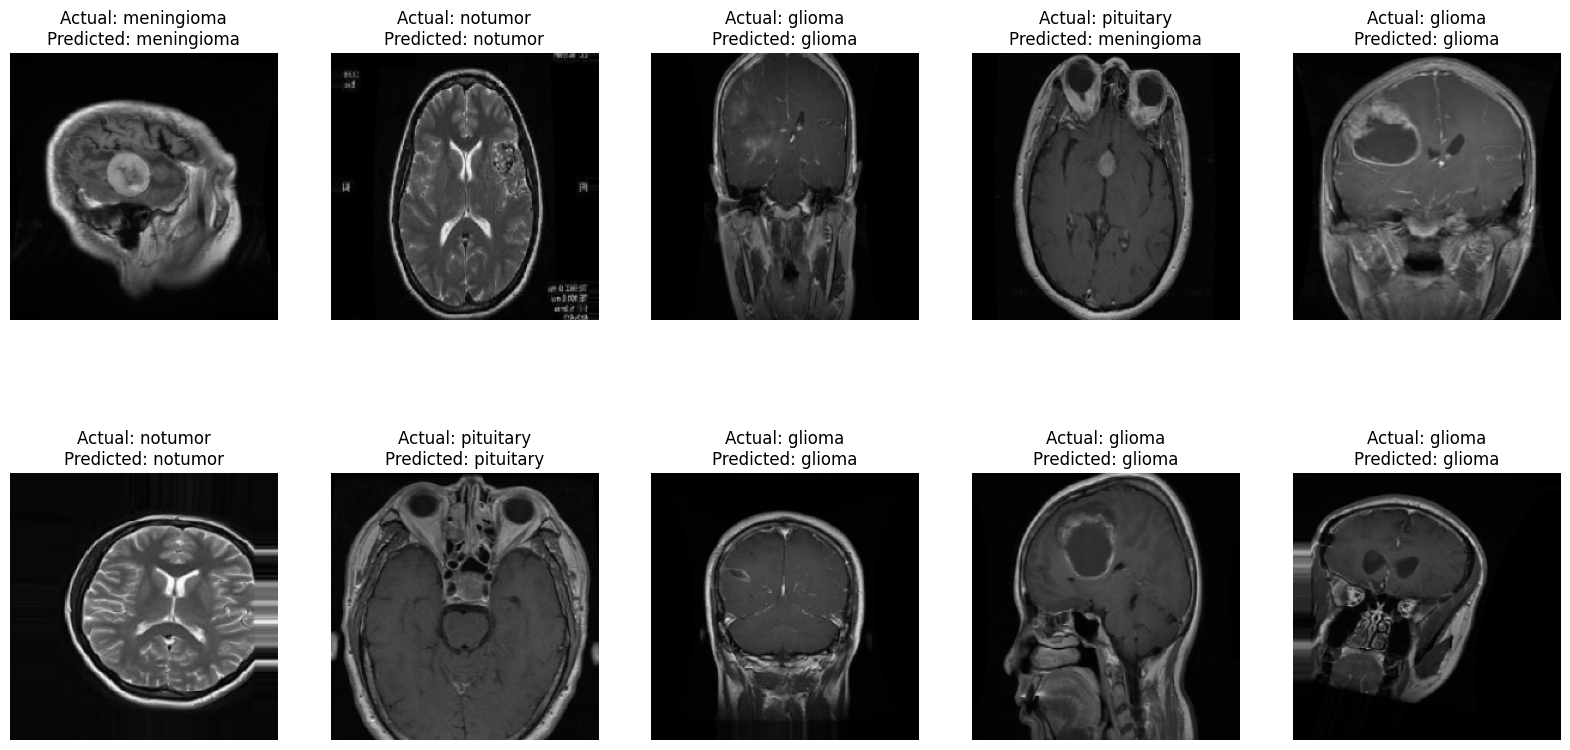

In [ ]:
num_images = 10
images, actual_classes, predicted_classes = get_predictions(train_generator, model, num_images)

# shows the image with their actual and predicteds class name
plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Actual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}')
    plt.axis('off')
plt.show()

In [ ]:
images, labels = next(validation_generator)

In [ ]:
images= images[1,:,:,:]

In [ ]:
images.shape

(224, 224, 3)

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Loads the images
path = r"/content/drive/MyDrive/Augmentation1/Augmentation/meningioma/Te-meTr_0004.jpg"
img = cv2.imread(path)
img = cv2.resize(img, (224, 224))

# Converts the images to a numpy arrays and normalizes it
img = np.array(img) / 255.0


img = np.expand_dims(img, axis=0)

predictions = model.predict(img)

# Assumings the model output is a probability distributions over classe
predicted_label = np.argmax(predictions, axis=-1)
predicted_index = np.argmax(predictions, axis=-1)[0]
# Get class indice from the generators
class_indices = validation_generator.class_indices

# Invert the class_indices dictionarys to map indice to class name
class_names = {v: k for k, v in class_indices.items()}

# Get the predicted class name
predicted_class = class_names[predicted_index]

print(f'Predicted Label Index: {predicted_index}')
print(f'Predicted Class Name: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted Label Index: 1
Predicted Class Name: meningioma
